In [16]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [17]:
data_path = './data/' #change this address to your local path
type_folders = {'power':'Power_Signals/', 'force':'Force_Signals/'}
signal_type = list(type_folders.keys())
data_buf = {}

In [18]:
def read_data_into_mem():
#   read all data into the global variable data_buf.
#   run this function once, at the the start-up, and refer to raw data only through data_buf later in the program.
#   data_buf = {'power':[array([time,val]),...], 'force':[array([time,val]),...]}  
    global data_buf, signal_type, type_folders
    
    for signal in signal_type:        
        data_buf[signal]=[]
        signal_path = data_path + type_folders[signal]
        file_list = os.listdir(signal_path)
        file_list.sort()
        for i,f in enumerate(file_list):
            data = pd.read_fwf(signal_path+f, header=None) # read_csv generates many NaN columns; no idea how to remove with its parameters
            data_buf[signal].append(data.values)
#             data.values[:,0] --- time; data.values[:,1] --- signal value;
            print( signal+' data %d/%d is read' % (i+1, len(file_list)))
read_data_into_mem()

power data 1/69 is read
power data 2/69 is read
power data 3/69 is read
power data 4/69 is read
power data 5/69 is read
power data 6/69 is read
power data 7/69 is read
power data 8/69 is read
power data 9/69 is read
power data 10/69 is read
power data 11/69 is read
power data 12/69 is read
power data 13/69 is read
power data 14/69 is read
power data 15/69 is read
power data 16/69 is read
power data 17/69 is read
power data 18/69 is read
power data 19/69 is read
power data 20/69 is read
power data 21/69 is read
power data 22/69 is read
power data 23/69 is read
power data 24/69 is read
power data 25/69 is read
power data 26/69 is read
power data 27/69 is read
power data 28/69 is read
power data 29/69 is read
power data 30/69 is read
power data 31/69 is read
power data 32/69 is read
power data 33/69 is read
power data 34/69 is read
power data 35/69 is read
power data 36/69 is read
power data 37/69 is read
power data 38/69 is read
power data 39/69 is read
power data 40/69 is read
power dat

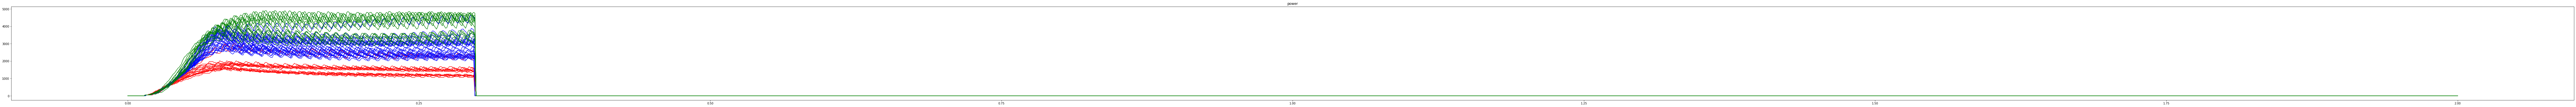

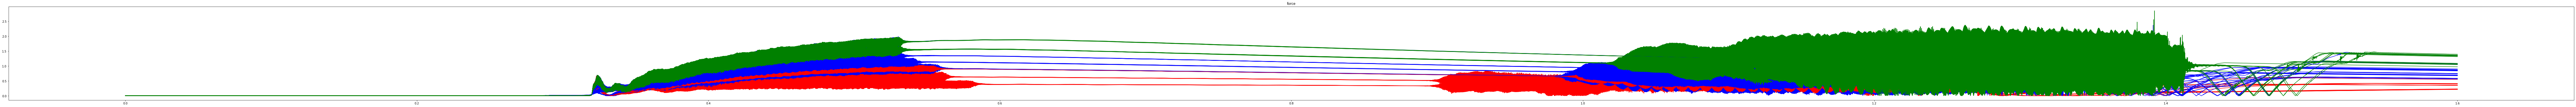

In [107]:
description_file = data_path + '003_EXPTABLE_withWeldClassification.xls'
descriptions = pd.read_excel(description_file, skiprows = list(range(0,6)))
descriptions = descriptions.drop(descriptions.index[0]) # delete the first row (which is invalid)
# descriptions.columns.values # column titles
# descriptions.iloc[0,:] ordescriptions.loc[1,:]   # get the first row with attributes

for signal in signal_type:
    fig = plt.figure(figsize = (160, 6))
    class_color={'I':'r', 'II':'g', 'III':'b'}
    l = len(data_buf[signal])
    for i in range(l):
        color_tmp = class_color[descriptions.loc[i+1,'Class Label']]
        plt.title(signal)
        plt.plot(data_buf[signal][i][:,0],data_buf[signal][i][:,1],color=color_tmp)
#         #         plt.legend()
    plt.show()
    


In [141]:
### 1. preprocessing
def raw_data_seg(raw_data, signal_type):
# return the beginning and the end index of the main signal segment
# for power signal, use threshold
# for force signal, use moving total variance
    if signal_type == 'power':
        threshold = 20        
        loc = np.where(raw_data[:,1] > threshold)[0]
        ind_l = loc[0]; ind_u = loc[-1];
        
    elif signal_type == 'force':
        threshold = 0.2
        threshold_antijit = 0.5
        moving_len = 100
        l = len(raw_data)
        moving_var = []
        for i in range(l-moving_len):
            var_tmp = 0
            for j in range(i+1,i+moving_len):
                var_tmp = var_tmp + abs(raw_data[j,1]-raw_data[j-1,1])
            moving_var.append(var_tmp)
        moving_var = np.array(moving_var)
        tmp = np.array(moving_var > threshold).astype(int)
        
        # tmp could be very noisy near the threshold; anti-jittering is needed
        for i in range(l-moving_len*2):
            tmp[i] = np.sum(tmp[i:i+moving_len])
        loc = tmp > moving_len*threshold_antijit
        
        ind_u = np.where(loc)[0][-1]
        loc = ~loc[0:ind_u-moving_len]
        ind_u = ind_u + moving_len
        ind_l = np.where(loc)[0][-1] + moving_len

    return ind_l, ind_u

data={} # refer to the list data for all later processes
seg_ind = {}
for signal in signal_type:        
    data[signal]=[]
    seg_ind[signal]=[]
    for i,sig in enumerate(data_buf[signal][:10]):
        (ind_l,ind_u) = raw_data_seg(sig, signal)
        data[signal].append(sig[ind_l:ind_u,:])
        seg_ind[signal].append([ind_l,ind_u])
#             data.values[:,0] --- time; data.values[:,1] --- signal value;
        print( signal+' data %d is done' % (i+1))


# # visualize the segmentation using
# plt.axvline(x=sig[ind_l,0])


power data 1 is done
power data 2 is done
power data 3 is done
power data 4 is done
power data 5 is done
power data 6 is done
power data 7 is done
power data 8 is done
power data 9 is done
power data 10 is done
force data 1 is done
force data 2 is done
force data 3 is done
force data 4 is done
force data 5 is done
force data 6 is done
force data 7 is done
force data 8 is done
force data 9 is done
force data 10 is done


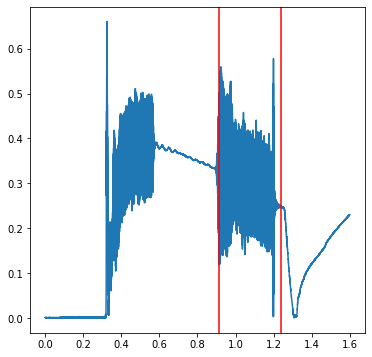

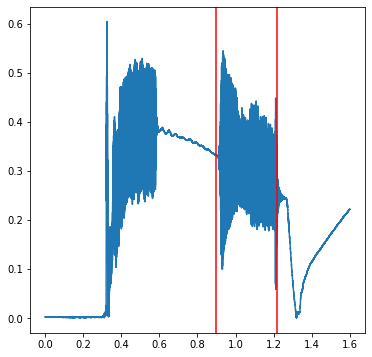

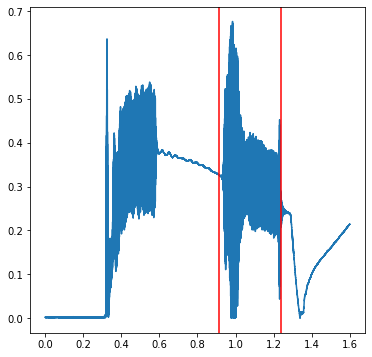

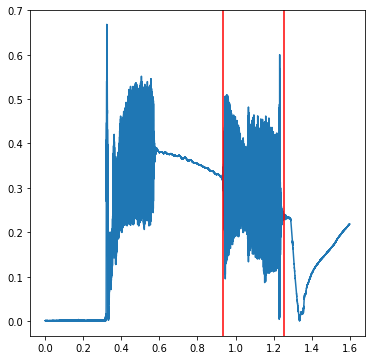

In [149]:
for i,sig in enumerate(data_buf['force'][1:5]):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(sig[:,0],sig[:,1])
    for ind in seg_ind['force'][i]:
        plt.axvline(x=sig[ind,0],color='r')
#     plt.axvline(x=sig[seg_ind['force'][i][1],0])

In [142]:
seg_ind['force']

[[91193, 124113],
 [89886, 121838],
 [91340, 124060],
 [93281, 125457],
 [93174, 125158],
 [93330, 126028],
 [93236, 126283],
 [89490, 121863],
 [89461, 121883],
 [98204, 129363]]

In [128]:
### 2. feature generation
feat_labels = ['welding_pressure', 'pre_height', 'post_height', 'height_change', 
               'time_f1', 'time_f2', 'time_f3', 'time_f4',
              'freq_f1', 'freq_f2', 'freq_f3', 'freq_f4']
features = {label:[] for label in feat_labels}

### a. using information in 'discriptions' to fill features

### b. using information in data['power'] to fill features

### c. using information in data['force'] to fill features

# # example:
# def features_freq(signal, label):
#     if label == 'freq_f1':
#         ...
#         return ...
#     elif label == ...
#     ...
    
# tmp = data['force']
# for sig in tmp:
#     for label in ['freq_f1', 'freq_f2', 'freq_f3', 'freq_f4']:
#         features[label].append(features_freq(sig, label))


In [103]:
features

{'welding_pressure': [],
 'pre_height': [],
 'post_height': [],
 'height_change': [],
 'time_f1': [],
 'time_f2': [],
 'time_f3': [],
 'time_f4': [],
 'freq_f1': [],
 'freq_f2': [],
 'freq_f3': [],
 'freq_f4': []}

In [130]:
from statistics import pvariance

def fisher_ratio(f1,f2):
    miu1 = np.mean(f1)
    miu2 = np.mean(f2)
    
    sigma1_square = pvariance(f1)
    print(sigma1_square)
    sigma2_square = pvariance(f2)
    print(sigma2_square)
    
#     l1=len(f1); l2=len(f2);
#     return np.power(miu1-miu2,2)*l1*l2/(l1*sigma1_square + l2*sigma2_square)/(l1+l2)
    return np.power(miu1-miu2,2)/(sigma1_square + sigma2_square)

print(fisher_ratio(np.array([2,2]),np.array([1,3])))

0
1
0.0


In [129]:
### 3. Fisher's ratio
welding_class = descriptions.loc[:,'Class Label'].values
classes = ['I','II','III']
class_index = {}
for c in classes:
    class_index[c] = np.where(welding_class == c)[0]

features_Fisher_ratio = {}
for label in feat_labels:
    features_Fisher_ratio[label] = []
    tmp = np.array(features[label])
    for c in classes[:2]:
        f_rat = fisher_ratio(tmp[class_index['III']],tmp[class_index[c]])
        features_Fisher_ratio[label].append(f_rat)



TypeError: 'numpy.int32' object is not iterable

In [131]:
### 4. Feature selection
feature_f_rat_sum = {label:np.sum(features_Fisher_ratio[label]) for label in feat_labels}
# visualize features

KeyError: 'pre_height'

In [134]:
### 5. Classification
feat_selected = ['welding_pressure', 'time_f1', 'freq_f1']
# plot histograms for each feature
for label in feat_selected:
    fig = plt.figure(figsize=(6, 6))
    feature_value = features[label]
    for c_ind in class_index:
        plt.hist(feature_value[c_ind], label = 'test data', bins=int(math.sqrt(len(feature_value[c_ind]))))
    plt.xlabel('bins')
    plt.ylabel('instances')
    plt.show()

# determine monitoring limits for each feature; using bayesian
# find misdetection rate
